# Convergence classes

BigDFT uses wavelets on a discretization grid to represent the wavefunction and density of the electronic system. The key parameters of a BigDFT calculation therefore are the grid spacing (noted `hgrids`) and the grid extension (noted `rmult`). The convergence of a given BigDFT calculation with respect to those two parameters can easily be studied via two classes: [HgridsConvergence](https://mmoriniere.gitlab.io/MyBigDFT/hgrids_convergence.html) and [RmultConvergence](https://mmoriniere.gitlab.io/MyBigDFT/rmult_convergence.html). Both will be used here in the case of the N$_2$ molecule with the LDA exchange-correlation potential.

In [1]:
# Import the relevant modules, classes and constant.
import numpy as np
import matplotlib.pyplot as plt
from mybigdft import Posinp, Atom, InputParams, Job
from mybigdft.globals import EV_TO_HA

## rmult convergence
    
The `RmultConvergence` class allows to run all the necessary calculations to determine the smallest grid extensions which must be used so that the energy error compared to the reference calculation (*i.e.*, with the largest `rmult` considered) lie within the required precision per atom. Using the smallest `rmult` as possible allows to save computational time because there are less grid points (or degrees of freedom). 

Note that there actually are two grids centered on the atoms of the system: a fine one with a shorter extension and a coarse one with a longer extension. They respectively correspond to the two numbers in the `reference` list given when initializing the `RmultConvergence` instance. These numbers will be decreased by 1 until the resulting energy lies outside the given `precision_per_atom` (here, 10 meV). The maximal number of jobs to be run is fixed to 6.

In [2]:
from mybigdft.workflows.convergences import RmultConvergence

atoms = [Atom('N', [0, 0, 0]), Atom('N', [0, 0, 1.1])]
pos = Posinp(atoms, units="angstroem", boundary_conditions="free")
base = Job(posinp=pos, run_dir="N2/rmult_convergence", name="N2")
rmc = RmultConvergence(base, reference=[9, 11], delta=[-1, -1], n_jobs=6,
                       precision_per_atom=0.01*EV_TO_HA)

The jobs in the queue have an extra attribute `param` which returns the value of rmult:

In [3]:
for job in rmc.queue:
    print(job.param)

[9.0, 11.0]
[8.0, 10.0]
[7.0, 9.0]
[6.0, 8.0]
[5.0, 7.0]
[4.0, 6.0]


You can run the calculations as usual:

In [4]:
rmc.run(nmpi=6, nomp=3)

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/N2/rmult_convergence/9.0_11.0
Logfile log-N2.yaml already exists!

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/N2/rmult_convergence/8.0_10.0
Logfile log-N2.yaml already exists!

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/N2/rmult_convergence/7.0_9.0
Logfile log-N2.yaml already exists!

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/N2/rmult_convergence/6.0_8.0
Logfile log-N2.yaml already exists!

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/N2/rmult_convergence/5.0_7.0
Logfile log-N2.yaml already exists!

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/N2/rmult_convergence/4.0_6.0
Logfile log-N2.yaml already exists!



Once the calculations are performed, a converged job is determined. It corresponds to the one with the smallest `rmult` so that the total energy of the system is below the convergence threshold, defined by the sum of the energy found for the largest `rmult` and the user defined precision per atom. It can be accessed via the `converged` attribute:

In [5]:
rmc.converged.param

[5.0, 7.0]

The result of the previous cell shows that `rmult = [5.0, 7.0]` gives converged results for the given precision per atom. To make sure that everything ran as expected, all the relevant data can be accessed via the `summary` method:

In [6]:
rmc.summary()

Requested precision per atom: 3.67e-04 (Ha)
----------------------------------------------------
    rmult     precision_per_atom (Ha)  is_converged 
----------------------------------------------------
 [9.0, 11.0]          0.00e+00             True     
 [8.0, 10.0]          1.09e-06             True     
  [7.0, 9.0]          3.71e-06             True     
  [6.0, 8.0]          4.96e-06             True     
  [5.0, 7.0]          2.75e-04             True     
  [4.0, 6.0]          2.31e-03            False     


### Plotting the convergence

The figure below shows the convergence of the total energy of the N$_2$ system with respect to the rmult. The threshold is also shown for comparison.

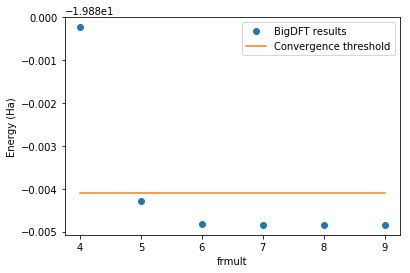

In [7]:
energies = [job.logfile.energy
            for job in rmc.queue if job.is_completed]
rmults = [job.param
          for job in rmc.queue if job.is_completed]
frmult = [rmult[0] for rmult in rmults]
n_at = len(rmc.queue[0].posinp)
threshold = min(energies) + n_at*rmc.precision_per_atom

fig=plt.figure()
fig.patch.set_facecolor('white')  # When dark background
plt.plot(frmult, energies,
         label="BigDFT results", marker="o", linestyle='')
plt.plot(frmult, [threshold]*len(energies),
         label="Convergence threshold")
plt.xlabel("frmult")
plt.ylabel("Energy (Ha)")
plt.legend()
plt.show()

Remember that there are actually two grids: one known as the fine grid, the other being the coarse one. The former is more expensive (from a computational point of view) than the latter, and should therefore have a smaller extension. One can perform a more refined rmult convergence by testing the convergence with respect to that fine grid extensions: this will be done after the convergence with respect to `hgrids`.

## hgrids convergence

The `HgridsConvergence` class allows to run all the necessary calculations to determine the largest `hgrids` which must be used so that the energy error compared to the reference calculation (with the lowest `hgrids` considered) lie within the required precision per atom. Using the largest `hgrids` as possible allows to save computational time because there are less grid points (or degrees of freedom).

In [8]:
from mybigdft.workflows.convergences import HgridsConvergence

atoms = [Atom('N', [0, 0, 0]), Atom('N', [0, 0, 1.1])]
pos = Posinp(atoms, units="angstroem", boundary_conditions="free")
inp = InputParams({"dft": {"rmult": rmc.converged.param}})
run_dir = "N2/hgrids_convergence/rm_{:.1f}_{:.1f}".format(*rmc.converged.param)
base = Job(inputparams=inp, posinp=pos, run_dir=run_dir, name="N2")
hgc = HgridsConvergence(base, reference=0.24, delta=0.02,
                        precision_per_atom=0.01*EV_TO_HA)

The jobs in the queue have an extra attribute `hgrids`:

In [9]:
for job in hgc.queue:
    print(job.param)

[0.24, 0.24, 0.24]
[0.26, 0.26, 0.26]
[0.28, 0.28, 0.28]
[0.3, 0.3, 0.3]
[0.32, 0.32, 0.32]
[0.34, 0.34, 0.34]
[0.36, 0.36, 0.36]
[0.38, 0.38, 0.38]
[0.4, 0.4, 0.4]
[0.42, 0.42, 0.42]


You can run the calculations as usual:

In [10]:
hgc.run(nmpi=6, nomp=3)

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/N2/hgrids_convergence/rm_5.0_7.0/0.24_0.24_0.24
Logfile log-N2.yaml already exists!

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/N2/hgrids_convergence/rm_5.0_7.0/0.26_0.26_0.26
Logfile log-N2.yaml already exists!

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/N2/hgrids_convergence/rm_5.0_7.0/0.28_0.28_0.28
Logfile log-N2.yaml already exists!

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/N2/hgrids_convergence/rm_5.0_7.0/0.30_0.30_0.30
Logfile log-N2.yaml already exists!

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/N2/hgrids_convergence/rm_5.0_7.0/0.32_0.32_0.32
Logfile log-N2.yaml already exists!

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/N2/hgrids_convergence/rm_5.0_7.0/0.34_0.34_0.34
Logfile log-N2.yaml already exists!

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/

/Users/maximemoriniere/Documents/Python/MyBigDFT/mybigdft/workflows/workflow.py:114: UserWarning: Some jobs of the workflow were not run.
  UserWarning)


Note that not all calculations were run: this is because the job with `hgrids` = 0.38 gave an energy that was above the requested precision per atom.

Once the calculations are performed, a converged job is determined. It corresponds to the one with the largest `hgrids` so that the total energy of the system is below the convergence threshold. It can be accessed via the `converged` attribute. Its `param` attribute can in turns be accessed:

In [11]:
hgc.converged.param

[0.36, 0.36, 0.36]

The result of the previous cell shows that `hgrids = 0.36` gives converged results for the given precision per atom. To make sure that everything ran as expected, all the relevant data can be accessed as follows:

In [12]:
hgc.summary()

Requested precision per atom: 3.67e-04 (Ha)
-----------------------------------------------------------
       hgrids        precision_per_atom (Ha)  is_converged 
-----------------------------------------------------------
 [0.24, 0.24, 0.24]          0.00e+00             True     
 [0.26, 0.26, 0.26]          3.89e-07             True     
 [0.28, 0.28, 0.28]          2.63e-05             True     
 [0.30, 0.30, 0.30]          4.53e-05             True     
 [0.32, 0.32, 0.32]          1.23e-04             True     
 [0.34, 0.34, 0.34]          1.88e-04             True     
 [0.36, 0.36, 0.36]          3.46e-04             True     
 [0.38, 0.38, 0.38]          5.86e-04            False     


It shows that everything ran as expected: the calculation with `hgrids = 0.36` has the largest `hgrids` while still having an energy below the requested threshold.

### Plotting the convergence

The figure below shows the convergence of the total energy of the N$_2$ system with respect to `hgrids`. The threshold value is also shown for comparison.

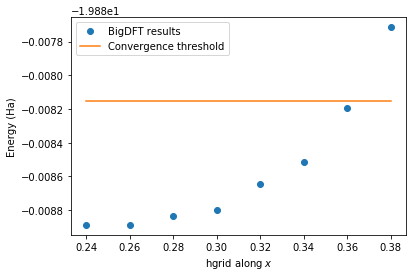

In [13]:
energies = [job.logfile.energy
            for job in hgc.queue if job.is_completed]
hgrids = [job.param 
          for job in hgc.queue if job.is_completed]
simple_hgrids = [hgrid[0] for hgrid in hgrids]
n_at = len(hgc.queue[0].posinp)
threshold = min(energies) + n_at*hgc.precision_per_atom

fig=plt.figure()
fig.patch.set_facecolor('white')  # When dark background
plt.plot(simple_hgrids, energies,
         label="BigDFT results", marker="o", linestyle='')
plt.plot(simple_hgrids, [threshold]*len(energies),
         label="Convergence threshold")
plt.xlabel("hgrid along $x$")
plt.ylabel("Energy (Ha)")
plt.legend()
plt.show()

## frmult convergence

We started the convergence study with a coarse grid having a larger extension than the fine grid. This means that the coarse grid extension is converged, but there might still be some room to use a smaller fine grid. This is the reason why the convergence study ends by looking only at the fine grid extension multiplying factor `frmult` (note that the delta value for `crmult` is 0):

In [14]:
[frm, crm] = rmc.converged.param
frmc = RmultConvergence(base, reference=[frm+2, crm], delta=[-1, 0],
                        n_jobs=5, precision_per_atom=0.01*EV_TO_HA)

In [15]:
frmc.run(nmpi=6, nomp=3)

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/N2/hgrids_convergence/rm_5.0_7.0/7.0_7.0
Logfile log-N2.yaml already exists!

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/N2/hgrids_convergence/rm_5.0_7.0/6.0_7.0
Logfile log-N2.yaml already exists!

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/N2/hgrids_convergence/rm_5.0_7.0/5.0_7.0
Logfile log-N2.yaml already exists!

/Users/maximemoriniere/Documents/Python/MyBigDFT/doc/source/notebooks/N2/hgrids_convergence/rm_5.0_7.0/4.0_7.0
Logfile log-N2.yaml already exists!



/Users/maximemoriniere/Documents/Python/MyBigDFT/mybigdft/workflows/workflow.py:114: UserWarning: Some jobs of the workflow were not run.
  UserWarning)


Nothing changed: `frmult = 5.0` gives converged results for the given precision:

In [16]:
frmc.summary()

Requested precision per atom: 3.67e-04 (Ha)
---------------------------------------------------
   rmult     precision_per_atom (Ha)  is_converged 
---------------------------------------------------
 [7.0, 7.0]          0.00e+00             True     
 [6.0, 7.0]          1.17e-05             True     
 [5.0, 7.0]          1.55e-04             True     
 [4.0, 7.0]          1.93e-03            False     


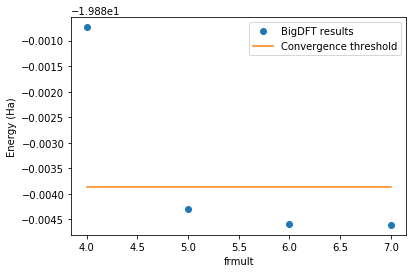

In [17]:
energies = [job.logfile.energy 
            for job in frmc.queue if job.is_completed]
rmults = [job.param
          for job in frmc.queue if job.is_completed]
frmult = [rmult[0] for rmult in rmults]
n_at = len(frmc.queue[0].posinp)
threshold = min(energies) + n_at*frmc.precision_per_atom
fig=plt.figure()
fig.patch.set_facecolor('white')  # When dark background
plt.plot(frmult, energies,
         label="BigDFT results", marker="o", linestyle='')
plt.plot(frmult, [threshold]*len(energies),
         label="Convergence threshold")
plt.xlabel("frmult")
plt.ylabel("Energy (Ha)")
plt.legend()
plt.show()

## Conclusion

The convergence with a precision per atom of 10 meV for the N$_2$ molecule is found using `hgrids = 0.36` and `rmult = [5.0, 7.0]` as input parameters for a BigDFT calculation.